In [34]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Paths
BASE_DIR = "data"
TRAIN_CSV = os.path.join(BASE_DIR, "train.csv")
TRAIN_IMG_DIR = os.path.join(BASE_DIR, "train")
META_CSV = os.path.join(BASE_DIR, "meta.csv")

Using device: cpu


In [35]:
df = pd.read_csv(TRAIN_CSV)
df['Path'] = df['Path'].str.replace("Train/", "", regex=False)

# Preview
print(df.head())
print("Unique classes:", df['ClassId'].nunique())

# Check image path validity
sample_path = os.path.join(TRAIN_IMG_DIR, df.iloc[0]['Path'])
print("Sample image exists:", os.path.exists(sample_path))

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                       Path  
0  20/00020_00000_00000.png  
1  20/00020_00000_00001.png  
2  20/00020_00000_00002.png  
3  20/00020_00000_00003.png  
4  20/00020_00000_00004.png  
Unique classes: 43
Sample image exists: True


In [36]:
CLASS_ID_TO_NAME = {
    0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)',
    9: 'No passing', 10: 'No passing > 3.5 tons', 11: 'Right-of-way at next intersection',
    12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles',
    16: 'No vehicles > 3.5 tons', 17: 'No entry', 18: 'General caution',
    19: 'Left curve', 20: 'Right curve', 21: 'Double curve', 22: 'Bumpy road',
    23: 'Slippery road', 24: 'Road narrows right', 25: 'Road work',
    26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing',
    29: 'Bicycles crossing', 30: 'Ice/snow', 31: 'Wild animals',
    32: 'End of all restrictions', 33: 'Turn right ahead', 34: 'Turn left ahead',
    35: 'Ahead only', 36: 'Straight or right', 37: 'Straight or left',
    38: 'Keep right', 39: 'Keep left', 40: 'Roundabout', 41: 'End of no passing',
    42: 'End of no passing > 3.5 tons'
}

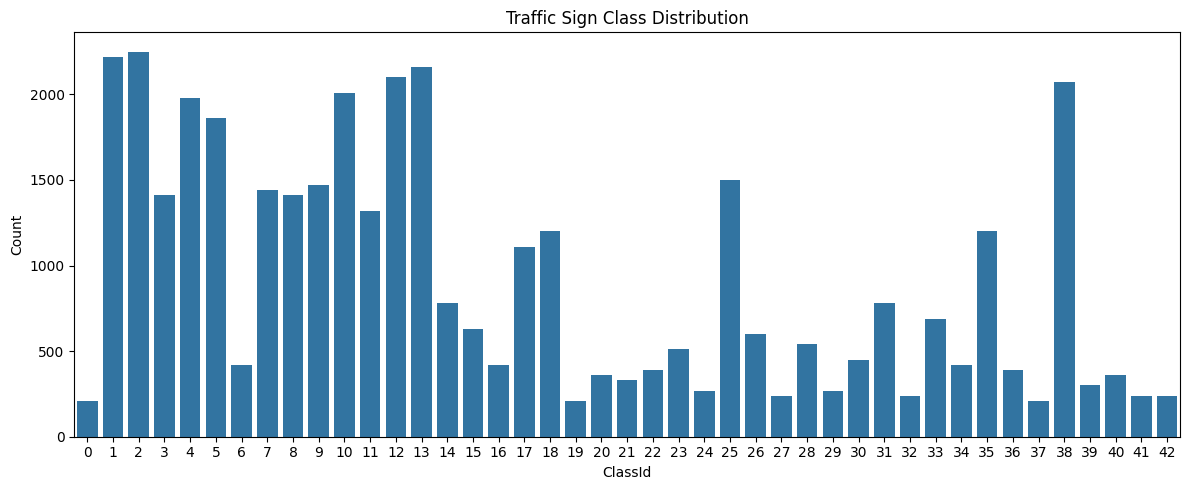

In [37]:
plt.figure(figsize=(12, 5))
sns.countplot(x=df['ClassId'])
plt.title("Traffic Sign Class Distribution")
plt.xlabel("ClassId")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [38]:
class GTSRBDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.iloc[idx]['Path'])
        image = Image.open(img_path).convert("RGB")
        label = int(self.data.iloc[idx]['ClassId'])

        if self.transform:
            image = self.transform(image)

        return image, label

In [39]:
# Split dataset
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['ClassId'], random_state=SEED)

# Transforms
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Datasets
train_dataset = GTSRBDataset(train_df, TRAIN_IMG_DIR, transform)
val_dataset = GTSRBDataset(val_df, TRAIN_IMG_DIR, transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [40]:
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(TrafficSignCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32 → 16
        x = self.pool(F.relu(self.conv2(x)))  # 16 → 8
        x = self.pool(F.relu(self.conv3(x)))  # 8 → 4
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [41]:
model = TrafficSignCNN().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [42]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

        train_acc = 100 * correct / len(train_loader.dataset)
        print(f"[Epoch {epoch+1}/{epochs}] Loss: {running_loss:.4f} | Train Acc: {train_acc:.2f}%")

        # Validation
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()

        val_acc = 100 * val_correct / len(val_loader.dataset)
        print(f"           >> Val Acc: {val_acc:.2f}%\n")

In [44]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

[Epoch 1/10] Loss: 14.0343 | Train Acc: 99.13%
           >> Val Acc: 99.43%

[Epoch 2/10] Loss: 13.4029 | Train Acc: 99.23%
           >> Val Acc: 99.34%

[Epoch 3/10] Loss: 13.0268 | Train Acc: 99.22%
           >> Val Acc: 99.57%

[Epoch 4/10] Loss: 12.2990 | Train Acc: 99.18%
           >> Val Acc: 99.48%

[Epoch 5/10] Loss: 8.7589 | Train Acc: 99.50%
           >> Val Acc: 99.52%

[Epoch 6/10] Loss: 12.7476 | Train Acc: 99.20%
           >> Val Acc: 99.31%

[Epoch 7/10] Loss: 10.8752 | Train Acc: 99.30%
           >> Val Acc: 99.29%

[Epoch 8/10] Loss: 9.2647 | Train Acc: 99.39%
           >> Val Acc: 99.40%

[Epoch 9/10] Loss: 11.7624 | Train Acc: 99.24%
           >> Val Acc: 99.46%

[Epoch 10/10] Loss: 8.6367 | Train Acc: 99.48%
           >> Val Acc: 99.36%



In [45]:
torch.save(model.state_dict(), "models/traffic_sign_cnn.pth")

In [46]:
def get_predictions(model, dataloader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)

y_true, y_pred = get_predictions(model, val_loader)

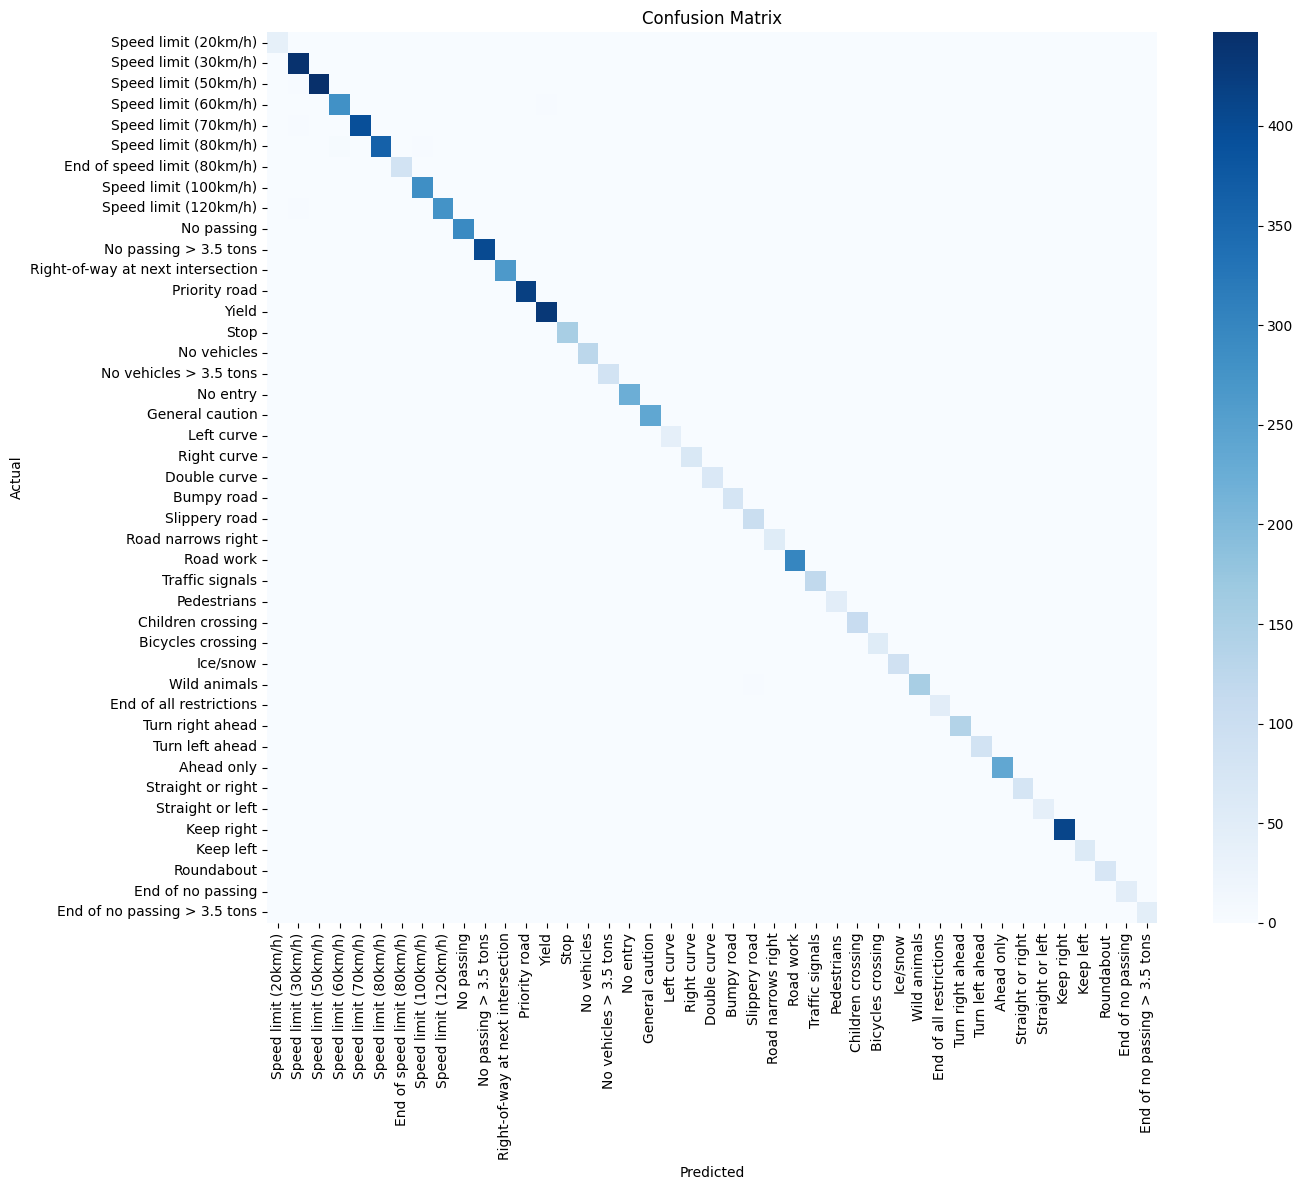

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get label names in correct order
label_names = [CLASS_ID_TO_NAME[i] for i in range(43)]

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [48]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=label_names))

                                   precision    recall  f1-score   support

             Speed limit (20km/h)       1.00      0.95      0.98        42
             Speed limit (30km/h)       0.98      1.00      0.99       444
             Speed limit (50km/h)       1.00      0.99      1.00       450
             Speed limit (60km/h)       0.98      0.99      0.99       282
             Speed limit (70km/h)       0.99      0.99      0.99       396
             Speed limit (80km/h)       0.99      0.98      0.98       372
      End of speed limit (80km/h)       0.99      1.00      0.99        84
            Speed limit (100km/h)       0.99      0.99      0.99       288
            Speed limit (120km/h)       1.00      0.98      0.99       282
                       No passing       1.00      1.00      1.00       294
            No passing > 3.5 tons       0.99      1.00      1.00       402
Right-of-way at next intersection       1.00      1.00      1.00       264
                    Prio